### Importing libraries and setting some global settings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import time
plt.rcParams['text.usetex'] = True

### JCIR basics
The JCIR model is an extension of the CIR model. The tracked quantity (in our case an intensity $\lambda$) moves according to the dynamics

$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$


where $\mu_\lambda$ represent the standard $\lambda$ that is reverted to, $\kappa$ is the reversion speed, $v_\lambda$ is the diffusion variance, and $dJ_t^{\alpha, \gamma}$ is a jump process with jump arrival rate $\alpha$ and jump sizes drawn from an exponential distribution with mean $\gamma$. (See e.g. Brigo Book pg. 76)

### Euler Maruyama implementation
One way to implement the JCIR process is to run an euler marayuma process for the diffusion element, and to simulate a list of jumps beforehand which are inserted when they occur, this is demonstrated in the first code cell below.


Jump Times: [ 3.67644857  7.15267587  8.38730392 22.98902685 28.39126101 43.42495028]
Jump Intensities: [3.923370974800064, 0.5022897889846705, 3.52532213842416, 0.6574468563646273, 2.207171221487058, 0.5165514180815278]
--- 0.012411117553710938 seconds ---


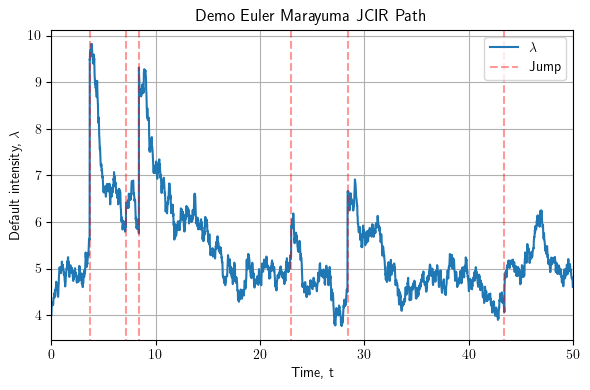

2506


In [ ]:
t0 = 0
T = 50

lambda0 = 4
mu = 5
kappa = 0.5
v = 0.25

alpha = 5/T # We should expect to see about 5 jumps,
gamma = mu/3 # With expected size mu/5

rand = Generator(PCG64())

## Generate Jumps
jump_times = t0 + (T-t0)*rand.random(rand.poisson(alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps
print("Jump Times: " + str(jump_times))
print("Jump Intensities: " + str(jump_intensitys))

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run diffusion model for let's say 2500 time steps over our 50 time units, i.e. dt = 1/50
N = 2500
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
lambdas = np.linspace(lambda0,lambda0,len(t_s))
gen_noise = (rand.normal(0,1,(len(t_s))))

# Time the run (this is very unscientific)
strt_time = time.time()

for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*gen_noise[i]
    lambdas[i] = lambdas[i-1] + kappa*(mu-lambdas[i-1])*dt + v*np.sqrt(lambdas[i-1])*dW

    # Add jump
    if not not jumps:
        if jumps[0][0] == t_s[i]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            jumps.pop(0)
            
    # Force positivity in case of unlikely failure
    lambdas[i] = max(lambdas[i],0)
    
print("--- %s seconds ---" %(time.time()-strt_time))

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.set_title("Demo Euler Marayuma JCIR Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['dashed'])
ax1.legend()
ax1.set_ylim(lims)
plt.show()



### A Transformed Implementation with Second Order Corrections
We can transform the problem into one on the square root of $\lambda_t$, if we name this variable $Y_t$, and discard the jumps for now we get the new SDE for non jump moments (Itô).
$$dY_t = \left(\frac{4\kappa \mu_\lambda Y_t^{-1} - (4\kappa + 1)Y_t}{8} \right)dt + \frac{1}{2}dW_t$$
We can run this between jumps and add them when they arrive as we did for the Euler case, but we can further improve on the model by adding second degree corrections, in our case this simplifies to 
$$Y_{t+1-} = Y_{t} + a\Delta_t + b\Delta_W + \frac{1}{2}(aa')\Delta_t^2 + \frac{1}{2}(a'b)\Delta_W \Delta_t$$
with 
$$a = \left(\frac{(4\kappa \mu_\lambda - v^2)Y_t^{-1} - (4 \kappa)Y_t}{8} \right)$$
$$a'= \left(\frac{-(4\kappa \mu_\lambda - v^2)Y_t^{-2} - (4 \kappa)}{8} \right)$$
$$b = (\frac{1}{2}v_\lambda)$$

Jump Times: [ 3.67644857  7.15267587  8.38730392 22.98902685 28.39126101 43.42495028]
Jump Intensities: [3.923370974800064, 0.5022897889846705, 3.52532213842416, 0.6574468563646273, 2.207171221487058, 0.5165514180815278]
[(np.float64(3.676448570199814), 3.923370974800064), (np.float64(7.15267587361546), 0.5022897889846705), (np.float64(8.387303924442612), 3.52532213842416), (np.float64(22.989026853121636), 0.6574468563646273), (np.float64(28.39126101044167), 2.207171221487058), (np.float64(43.424950283160754), 0.5165514180815278)]
Jumped
Jumped
Jumped
Jumped
Jumped
Jumped
--- 0.014986753463745117 seconds ---


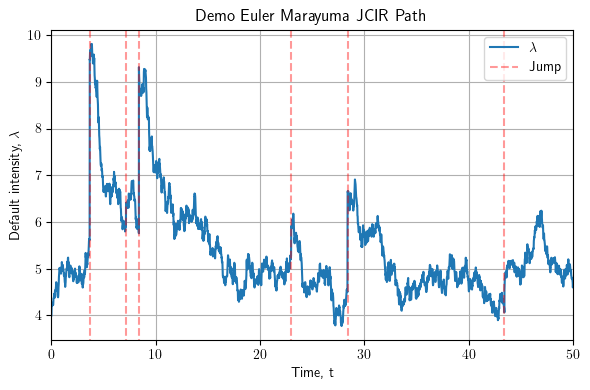

In [ ]:
# Recreate the jump list
print("Jump Times: " + str(jump_times))
print("Jump Intensities: " + str(jump_intensitys))
jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities
print(jumps)

## Clear lambdas to preven cross contamination, preallocate transformed var
Y_s = np.linspace(np.sqrt(lambda0), np.sqrt(lambda0), len(t_s)) 
lambdas = np.linspace(lambda0,lambda0,len(t_s))

## Run and time the transformed model on the same noise
strt_time = time.time()

for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*gen_noise[i]
    
    a = ((4*kappa*mu - v**2)*Y_s[i-1]**(-1) - (4*kappa)*Y_s[i-1])/8
    ap = (-(4*kappa*mu - v**2)*Y_s[i-1]**(-2) - (4*kappa))/8
    b = (1/2)*v
    Y_s[i] = Y_s[i-1] + a*dt + b*dW + (1/2)*a*ap*(dt**2) + (1/2)*(ap*b)*dW*dt
    lambdas[i] = Y_s[i]**2

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            Y_s[i] = np.sqrt(lambdas[i])
            jumps.pop(0)

print("--- %s seconds ---" %(time.time()-strt_time))

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.set_title("Demo Euler Marayuma JCIR Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['dashed'])
ax1.legend()
ax1.set_ylim(lims)
plt.show()

### Commenting on the results
The first concern to be had was with running time, both financial models appear to run very fast and in comparable time, there is no real memory allocation issue, since the models are so light, and the fancier model only uses one extra array of floats with size N.

We can see that for many datapoints they create an essentialy indistiguishable graph which points to that both are working as they should be, when we turn N down to very low numbers (5 time steps for instance) the fancier model explodes since the laplace expansion it uses intuitively needs somewhat small dt to begin working, at N = 50 they again appear essentialy identical, so it seems neither is really capturing signifigantly more information than the other.

Frankly either could work, and while the transformed and extended model should perform better in theory as well as being what Klunkar would suggest it exhibits some behavioural quirks that mean we may need to think more about which to use.